### Exam ADA

In [534]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier



## Question 1: Exploring the data - 30 points
In this part, you will explore the data to address the curiosities of the demanding Professor Oak.

3. (10 points) Professor Oak suspects that Pokémon in the _grass_ class have a stronger regular attack than those in the _rock_ class. Check if he is right and convince him of your conclusion with statistical arguments.
   Note: If there are Pokémon that are in both classes, discard them.
   Note: You may assume that the distribution of the regular attack feature is normal for all Pokémon classes.
4. (10 points) Professor Oak reveals to you that he has built a backdoor into every Pokedex in the world and that he is secretly dumping the memory of all devices to his servers. He expects to have the records of 1 billion combats soon, and one machine won’t be enough to handle all this data, so he wants you to use Spark. Your task: Solve problem 2iv above (“list the names of the 10 Pokémon with the largest number of victories”) with a Spark implementation in Python. The output should be a Python list with 10 names sorted in descending order of number of victories.
   Note: You don’t need to run the Spark code -- just list it! You should assume that you have two DataFrames (already loaded) called `pokemon` and `combats`, with the same schema as the small CSV files you’ve been working with above.

In [370]:
df_pokemon = pd.read_csv("pokemon.csv")
df_combats = pd.read_csv('combats.csv')

In [12]:
df_pokemon.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


### 1. Exploring data

Let's explore the data, so we get a sense of the Pokémon world!

##### Sanity check

In [53]:
df_pokemon[df_pokemon['Class 1'].isna()] ## all pokmeon have classes => this is empty
df_pokemon[df_pokemon['Name'].isna()] ## one pokemon without name, what do we do?
# I decide not to remove it, since it might be missing data - or unkown name

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,False


##### How many classes are there?

In [139]:
len(set(df_pokemon['Class 1']) & set(df_pokemon['Class 2']))

18

##### How many pokemon are there? How many combats?

In [142]:
print(len(df_pokemon))
print(len(df_combats))

800
50000


##### What is the distribuation of the classes?

In [72]:
# Combine class 1 and class 2
df_class_2 = df_pokemon.copy()
df_class_2['Class'] = df_class_2['Class 2']
df_class_2.loc[:, df_class_2.columns != 'Class 1']

df_class_1 = df_pokemon.copy()
df_class_1['Class'] = df_class_1['Class 1']
df_class_1.loc[:, df_class_1.columns != 'Class 2']
;

''

In [81]:
df_pokemon_one_class = df_class_1.append(df_class_2, ignore_index=True)
df_pokemon_one_class = df_pokemon_one_class.loc[:, df_pokemon_one_class.columns != 'Class 1']
df_pokemon_one_class = df_pokemon_one_class.loc[:, df_pokemon_one_class.columns != 'Class 2']
df_pokemon_one_class.reset_index(inplace=True)

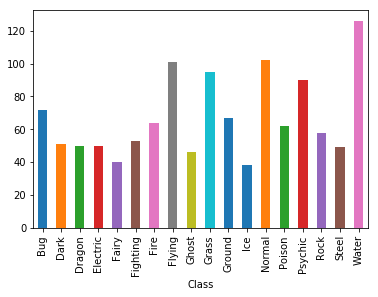

In [93]:
df_pokemon_one_class.groupby('Class').count()['pid'].plot.bar()

##### Describe

In [99]:
df_pokemon.describe()

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


##### Attack and Defense distribution

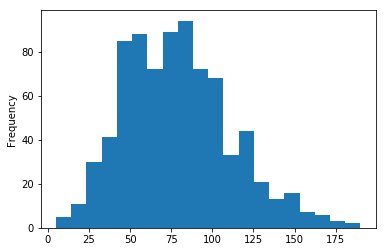

In [106]:
df_pokemon.Attack.plot.hist(bins=20)

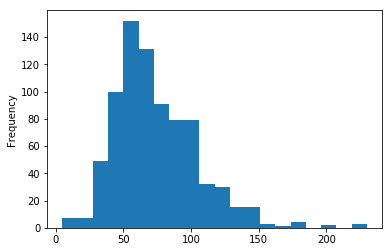

In [108]:
df_pokemon.Defense.plot.hist(bins=20)

##### 2. (4 points) Compare the probability distribution of the “regular attack” feature with that of the “regular defense” feature. In particular,


##### 2.1. visualize the relation between these two variables using an appropriate plot;

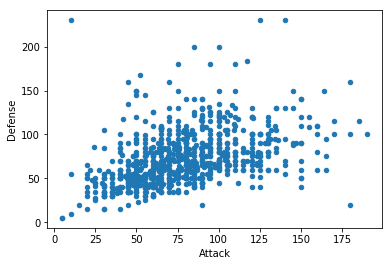

In [113]:
# See if strong pokemon in attack are alos strong in defense
df_pokemon.plot.scatter('Attack', 'Defense')

In [123]:
df_pokemon_with_ratio = df_pokemon.copy()
df_pokemon_with_ratio['Ratio'] = df_pokemon['Attack'] / df_pokemon['Defense']

#####   2.2 list the names of the 3 Pokémon with highest attack-over-defense ratio;

In [134]:
df_pokemon_with_ratio.sort_values('Ratio', ascending=False).head(3)

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Ratio
429,430,DeoxysAttack Forme,Psychic,NaN,50,180,20,180,20,150,True,9.00
347,348,Carvanha,Water,Dark,45,90,20,65,20,65,False,4.50
19,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,False,3.75


##### 2.3 list the names of the 3 Pokémon with lowest attack-over-defense ratio;

In [145]:
df_pokemon_with_ratio.sort_values('Ratio', ascending=True).head(3)

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Ratio
230,231,Shuckle,Bug,Rock,20,10,230,10,230,5,False,0.043478
139,140,Magikarp,Water,NaN,20,10,55,15,20,80,False,0.181818
484,485,Bronzor,Steel,Psychic,57,24,86,24,86,23,False,0.279070


##### 2.4. list the names of the 10 Pokémon with the largest number of victories.

In [177]:
df_count_winner = df_combats.groupby('Winner').count()['First_pokemon'].to_frame()
df_top_ten_winner = df_count_winner.sort_values('First_pokemon', ascending=False).head(10)
df_top_ten_winner.join(df_pokemon.set_index('pid'))['Name'].to_frame()

,Name
Winner,
163,Mewtwo
154,Aerodactyl
438,Infernape
428,Jirachi
432,Deoxys Speed Forme
314,Slaking
214,Murkrow
394,Mega Absol
249,Mega Houndoom


### 3
(10 points) Professor Oak suspects that Pokémon in the grass class have a stronger regular attack than those in the rock class. Check if he is right and convince him of your conclusion with statistical arguments. Note: If there are Pokémon that are in both classes, discard them. Note: You may assume that the distribution of the regular attack feature is normal for all Pokémon classes.

In [179]:
## Discared the one in both classes

In [192]:
df_pokemon[(df_pokemon['Class 1'] == 'Grass') & (df_pokemon['Class 2'] == 'Rock')]

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary


In [195]:
df_pokemon[(df_pokemon['Class 2'] == 'Grass') & (df_pokemon['Class 1'] == 'Rock')]

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
377,378,Lileep,Rock,Grass,66,41,77,61,87,23,False
378,379,Cradily,Rock,Grass,86,81,97,81,107,43,False


In [236]:
## Remove those by hand
df_pokemon_non_rock = df_pokemon.drop([377, 378])

In [200]:
len(df_pokemon_non_rock)

798

In [208]:
df_pokemon_grass = df_pokemon_non_rock[(df_pokemon_non_rock['Class 1'] == 'Grass') | \
                                       (df_pokemon_non_rock['Class 2'] == 'Grass')]

In [211]:
df_pokemon_rock = df_pokemon_non_rock[(df_pokemon_non_rock['Class 1'] == 'Rock') | \
                                    (df_pokemon_non_rock['Class 2'] == 'Rock')]

In [216]:
df_pokemon_grass.Attack.describe()

count     93.000000
mean      73.731183
std       24.179645
min       27.000000
25%       59.000000
50%       70.000000
75%       95.000000
max      132.000000
Name: Attack, dtype: float64

In [218]:
df_pokemon_rock.Attack.describe()

count     56.000000
mean      91.785714
std       34.805284
min       10.000000
25%       63.000000
50%       92.500000
75%      116.250000
max      165.000000
Name: Attack, dtype: float64

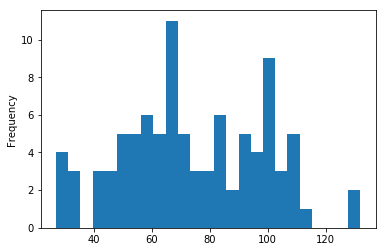

In [232]:
df_pokemon_grass.Attack.plot.hist(bins=25)

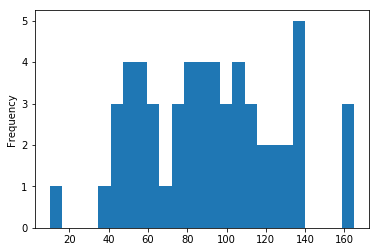

In [237]:
df_pokemon_rock.Attack.plot.hist(bins=25)

#### Conclusion
We assume both values come from a normal distribution, therefore the grass type we have a mean of 73 vs 91 for the rock, which doesn't match Prof. Oaks suspiction. Looking at the standard deviation we see, 24 for grass and 34 for rock. 

#### 4. Spark

list the names of the 10 Pokémon with the largest number of victories.

In [246]:

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [274]:
# Are you talking here about Pandas DataFrame or Spark DataFrame? Dafqu, this word is overloaded, be specific! 
# I assume these are Spark dataframes
pokemon = spark.read.format('csv').option('header', 'true').load('pokemon.csv')
combats = spark.read.format('csv').option('header', 'true').load('combats.csv')

In [304]:
combats.groupBy('Winner').count().sort(desc('count')).registerTempTable('winner')
pokemon.registerTempTable('pokemon')

In [311]:
s = '''
select Name
from pokemon p
    join winner w on w.Winner = p.pid
order by w.count desc
limit 10
'''
result2 = spark.sql(s)
result2.show()

+------------------+
|              Name|
+------------------+
|            Mewtwo|
|         Infernape|
|        Aerodactyl|
|           Jirachi|
|Deoxys Speed Forme|
|           Slaking|
|           Murkrow|
|        Mega Absol|
|     Mega Houndoom|
|     Mega Rayquaza|
+------------------+



### Question 2: Prediction - 40 points

In [424]:
# 1. Generate the feature vectors and the labels to train your model.

In [425]:
# convert categories to boolean values

In [485]:
df_dummy_class_one = pd.get_dummies(df_pokemon['Class 1'])
df_dummy_class_two = pd.get_dummies(df_pokemon['Class 2'])
df_dummy = df_dummy_class_one + df_dummy_class_two
df_pokemon_feature = df_pokemon.copy()

In [486]:
df_pokemon_feature.Legendary = df_pokemon_feature.Legendary.astype(int)
df_pokemon_feature.head()
df_pokemon_feature = df_pokemon_feature.loc[:, df_pokemon_feature.columns != 'Class 1']
df_pokemon_feature = df_pokemon_feature.loc[:, df_pokemon_feature.columns != 'Class 2']
df_pokemon_feature = df_pokemon_feature.loc[:, df_pokemon_feature.columns != 'Name']
df_pokemon_feature = df_pokemon_feature.join(df_dummy)

In [527]:
df_features_x = df_combats.merge(df_pokemon_feature, how='left', 
                               left_on='First_pokemon', right_on='pid' )
df_features_x = df_features_x.merge(df_pokemon_feature, how='left', 
                               left_on='Second_pokemon', 
                                right_on='pid', suffixes=('_first', '_second'))
df_features_x = df_features_x.loc[:, df_features_x.columns != 'First_pokemon']
df_features_x = df_features_x.loc[:, df_features_x.columns != 'Second_pokemon']
df_features_x = df_features_x.loc[:, df_features_x.columns != 'Winner']
df_features_x = df_features_x.loc[:, df_features_x.columns != 'pid_first']
df_features_x = df_features_x.loc[:, df_features_x.columns != 'pid_second']

In [531]:
## Thse are my x values
df_features_x.head()

,HP_first,Attack_first,Defense_first,Sp. Atk_first,Sp. Def_first,Speed_first,Legendary_first,Bug_first,Dark_first,Dragon_first,...,Ghost_second,Grass_second,Ground_second,Ice_second,Normal_second,Poison_second,Psychic_second,Rock_second,Steel_second,Water_second
0,50,64,50,45,50,41,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,91,90,72,90,129,108,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,55,40,85,80,105,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,40,40,40,70,40,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,70,60,125,115,70,55,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [660]:
## These are my labels
df_first = df_combats[df_combats.First_pokemon == df_combats.Winner].copy()
df_second = df_combats[df_combats.Second_pokemon == df_combats.Winner].copy()

In [661]:
df_features_y = df_combats.copy()

In [662]:
df_first['Y'] = '0'
df_second['Y'] = '1'
df_features_y = df_first.append(df_second)['Y'].to_frame()

##### 2.2 (5 points) How does your model handle categorical features and Pokémon with multiple classes?
=> I convert them to dummy variables, multiple classes are handled correctly, such that if pokemon has rock and grass category, the dummy variable for grass and rock is set to true

###### 2.3 Random forest (10 points) Train a random forest to predict the winner of a match based on the available features. To do so, split the full dataset randomly into a training set (90%) and a testing set (10%), and try different values of the number of estimators (n_estimators, try values 10, 25, 50, 100) and the maximum tree depth (max_depth, try values 2, 4, 10). Do this manually, without using any scikit-learn helpers.

In [713]:
def do_train(est, dept):
    df_train_x = df_features_x.sample(frac=0.9)
    df_train_y = df_features_y.loc[df_train_x.index]

    df_test_x = df_features_x.loc[(set(df_features_x.index) - set(df_train_x.index))]
    df_test_y = df_features_y.loc[(set(df_features_y.index) - set(df_train_y.index))]

    model = RandomForestClassifier(n_estimators=est, max_depth=dept)
    model.fit(df_train_x.values, df_train_y.values.ravel())

    predictions = model.predict(np.array(df_test_x.values))

    predicted = np.array(predictions.astype(int))
    true_values = df_test_y.values.ravel().astype(int)

    TP = np.sum(np.logical_and(predicted == 1, true_values == 1))
    TN = np.sum(np.logical_and(predicted == 0, true_values == 0))
    FP = np.sum(np.logical_and(predicted == 1, true_values == 0))
    FN = np.sum(np.logical_and(predicted == 0, true_values == 1))

    accuracy = (TP+TN)/len(true_values)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 1/(0.5*(1/precision+1/recall))

    print(est, dept, "Accuracy", np.round(accuracy, 3), 
          "Precision", np.round(precision, 3), 
          "Recall", np.round(recall, 3), 
          "F1", np.round(f1, 3))

In [714]:
for est in [10, 25, 50, 100]:
    for dept in [2, 4, 10]:
        do_train(est, dept)

10 2 Accuracy 0.76 Precision 0.762 Recall 0.802 F1 0.782
10 4 Accuracy 0.782 Precision 0.755 Recall 0.85 F1 0.8
10 10 Accuracy 0.918 Precision 0.931 Recall 0.915 F1 0.923
25 2 Accuracy 0.759 Precision 0.723 Recall 0.868 F1 0.789
25 4 Accuracy 0.833 Precision 0.818 Recall 0.875 F1 0.846
25 10 Accuracy 0.911 Precision 0.924 Recall 0.907 F1 0.915
50 2 Accuracy 0.781 Precision 0.755 Recall 0.856 F1 0.803
50 4 Accuracy 0.834 Precision 0.818 Recall 0.881 F1 0.849
50 10 Accuracy 0.911 Precision 0.919 Recall 0.913 F1 0.916
100 2 Accuracy 0.797 Precision 0.766 Recall 0.879 F1 0.818
100 4 Accuracy 0.849 Precision 0.828 Recall 0.899 F1 0.862
100 10 Accuracy 0.921 Precision 0.926 Recall 0.922 F1 0.924


###### (5 points) Summarize and describe the results you obtain when training on 90% and testing on 10% of the data. What is the best combination of the two hyperparameters (number of estimators and maximum tree depth)?

Analyzing the result, it seems, that the best hyperparameter for our setting is, n_estimator=50 and depth=10, because this is the value which max. our F1 score. 
F1 score has been chose, because it gives a good measure for classification. 


###### (5 points) Could the above training/testing setup potentially lead to wrong conclusions regarding the best hyperparameter setting? If so, describe why, and how you would address the problem. (Hint: think about how you’re making use of the data during training and testing).

###### (7 points) Implement your solution to the problem you’ve identified in the previous subquestion (5), and show and describe your results.

We can extend the range of hyperparameter, because there might be local minimia. 
Let's check different ranges

In [726]:
for est in [20, 24, 28, 32, 36]:
    for dept in np.linspace(1, 50, 3):
        do_train(est, dept)

20 1.0 Accuracy 0.757 Precision 0.722 Recall 0.884 F1 0.795
20 6.444444444444445 Accuracy 0.872 Precision 0.878 Recall 0.878 F1 0.878
20 11.88888888888889 Accuracy 0.912 Precision 0.918 Recall 0.917 F1 0.917
20 17.333333333333336 Accuracy 0.935 Precision 0.939 Recall 0.936 F1 0.937
20 22.77777777777778 Accuracy 0.932 Precision 0.946 Recall 0.927 F1 0.937
20 28.22222222222222 Accuracy 0.943 Precision 0.953 Recall 0.939 F1 0.946
20 33.66666666666667 Accuracy 0.946 Precision 0.959 Recall 0.939 F1 0.949
20 39.111111111111114 Accuracy 0.941 Precision 0.956 Recall 0.934 F1 0.945
20 44.55555555555556 Accuracy 0.942 Precision 0.95 Recall 0.937 F1 0.943
20 50.0 Accuracy 0.944 Precision 0.953 Recall 0.939 F1 0.946
24 1.0 Accuracy 0.724 Precision 0.701 Recall 0.829 F1 0.76
24 6.444444444444445 Accuracy 0.866 Precision 0.869 Recall 0.882 F1 0.876
24 11.88888888888889 Accuracy 0.92 Precision 0.925 Recall 0.92 F1 0.923
24 17.333333333333336 Accuracy 0.935 Precision 0.939 Recall 0.936 F1 0.938
24 22.

=> This gives us, a new hyperparameter which is n_estimator = **36** and n_depth = **33**

###### (5 points) Finally, Professor Oak wants to know what the most predictive features are. Plot feature importance as a bar plot representing the 10 most predictive variables.

In [738]:
df_features = pd.DataFrame.from_records(list(zip(list(df_train_x.columns), list(model.feature_importances_))))

In [744]:
df_features.sort_values(1, ascending=False).head(20)

,0,1
5,Speed_first,0.322165
30,Speed_second,0.306290
1,Attack_first,0.049876
26,Attack_second,0.045456
3,Sp. Atk_first,0.039568
28,Sp. Atk_second,0.036784
29,Sp. Def_second,0.024544
0,HP_first,0.022734
4,Sp. Def_first,0.021345
25,HP_second,0.020059


=> According to the above list, these are the top 10 predictive values: 
1. Speed
2. Attack, 
3. SP. Attack
4. Sp. Defense, 
5. HP
6. Defense, 
7. Flying, 
8. Legendary, 
9. Ghost, <= Category
10. Rock <= Category



### Question 3: Ranking - 30 points

In [756]:
df_first = df_combats['First_pokemon'].to_frame()
df_first['Pokemon'] = df_first['First_pokemon']
df_first = df_first.loc[:, df_first.columns != 'First_pokemon']

In [349]:
df_second = df_combats['Second_pokemon'].to_frame()
df_second['Pokemon'] = df_second['Second_pokemon']
df_second = df_second.loc[:, df_second.columns != 'Second_pokemon'];

In [359]:
df_all = df_first.append(df_second, ignore_index=False, sort=False)
df_count_battles = df_all.groupby('Pokemon').size().to_frame()
df_count_battles.head(3)

,0
Pokemon,
1,133
2,121
3,132


In [360]:
### santiy check

In [379]:
print(len(df_combats[df_combats['First_pokemon'] == 1]) + len(df_combats[df_combats['Second_pokemon'] == 1]))
print(len(df_combats[df_combats['First_pokemon'] == 3]) + len(df_combats[df_combats['Second_pokemon'] == 3]))

133
132


In [399]:
df_winner = df_combats.groupby('Winner').size().to_frame();


In [402]:
len(df_winner)

783

In [415]:
df_combats_ranking = df_combats.copy()
df_combats_ranking['CountWinner'] = df_winner[0]
df_combats_ranking['CountBattles'] = df_count_battles[0]

In [416]:
df_combats_ranking = df_combats_ranking.fillna(0)
df_combats_ranking['Ratio'] = df_combats_ranking['CountWinner'] / df_combats_ranking['CountBattles']

In [745]:
# Top pokemon with highest rating
df_top_best = df_combats_ranking.sort_values('Ratio', ascending=False).head(10)

In [747]:
df_top_best = df_top_best.merge(df_pokemon_feature, how='left', 
                               left_on='First_pokemon', right_on='pid' )
df_top_best = df_top_best.merge(df_pokemon_feature, how='left', 
                               left_on='Second_pokemon', 
                                right_on='pid', suffixes=('_first', '_second'))

In [755]:
df_top_best[['Speed_first', 'Speed_second', 'Attack_first', 'Attack_second', 
             'Sp. Atk_first', 'Sp. Atk_second', 'Sp. Def_second']]

,Speed_first,Speed_second,Attack_first,Attack_second,Sp. Atk_first,Sp. Atk_second,Sp. Def_second
0,55,45,85,45,85,45,70
1,25,95,85,40,30,75,85
2,65,68,65,100,80,97,81
3,50,70,66,125,81,60,70
4,86,29,65,22,105,27,30
5,115,100,125,100,125,80,85
6,50,60,105,55,55,45,40
7,43,95,82,90,46,110,80
8,120,150,85,135,105,70,95
9,52,115,104,70,94,65,65


Discuss your results about feature importance from question 2.7 (regarding feature importance) in this context.

=> The predicted features seems to influence the winning ration ( but not as much as one would hope )

#### (10 points) A simple method for identifying the strongest Pokémon using this graph is to compute the matrix A = G + G2. Consider a given row of A; summing up all elements of that row results in a dominance score for the respective Pokémon. Explain what this score represents and why it may be interpreted as capturing the dominance of a Pokémon.

In [768]:
df_small_combat = df_combats[(df_combats.First_pokemon < 25) & (df_combats.Second_pokemon < 25)]

In [769]:
df_nr_of_times_battle = pd.crosstab(df_small_combat.First_pokemon, df_small_combat.Second_pokemon)

In [773]:
df_small_combat_winner_left = df_small_combat[df_small_combat.First_pokemon == df_small_combat.Winner]

In [776]:
df_nr_of_times_battle - pd.crosstab(df_small_combat_winner_left.First_pokemon, 
            df_small_combat_winner_left.Second_pokemon)

Second_pokemon,1,2,3,4,5,6,10,11,13,14,15,16,17,19,20,21
First_pokemon,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
4,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
6,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
7,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
8,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
